# Autoenkodery i GAN

## Implementacja prostego autoenkodera

In [ ]:
from keras.datasets import mnist
import numpy as np

Załaduj zbiór MNIST:

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

In [ ]:
# we will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(60000, 784)


Pierwszy autoenkoder:

In [ ]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Model dla kodera:

In [ ]:
# this model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

Model dla dekodera:

In [ ]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Wytrenowanie autoenkodera do rekonstrukcji cyfr MNIST:

In [ ]:
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6002 - val_loss: 0.1733
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1140 - val_loss: 0.0320
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0249 - val_loss: 0.0121
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0063
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4199e-04 - val_loss: 7.8312e-04
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4001e-04 - val_loss: 6.2446e-04
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━

Wizualizacja:

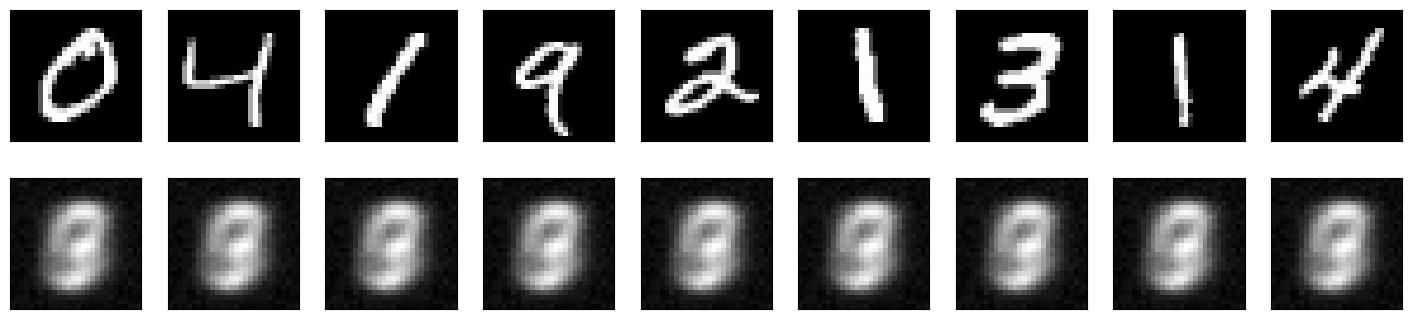

In [ ]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Autoenkoder konwolucyjny (convolutional autoencoder)

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()   # TODO Load MNIST data and convert it to [0,1] range like before

# To train it, we will again use the original MNIST digits but with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

In [ ]:
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_imgs = autoencoder.predict(x_test)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.3189 - val_loss: 0.1423
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1377 - val_loss: 0.1251
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1239 - val_loss: 0.1177
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1173 - val_loss: 0.1126
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1129 - val_loss: 0.1105
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1102 - val_loss: 0.1078
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1081 - val_loss: 0.1061
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1067 - val_loss: 0.1051
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1058 - val_loss: 0.1034
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1046 - val_loss: 0.1027
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1032 - val_loss: 0.1015
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 

Opracuj wykres:

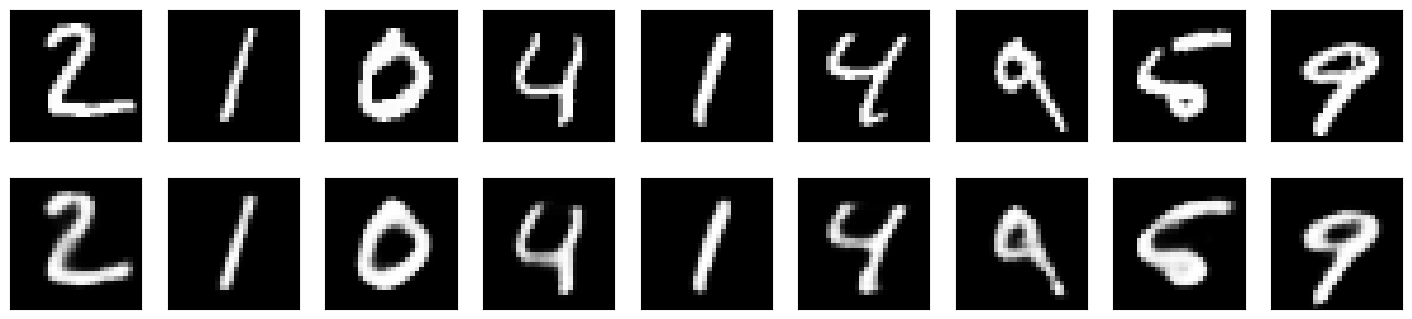

In [ ]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()